In [ ]:
!wget https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip ml-latest-small.zip


--2025-12-28 08:36:41--  https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.96.204
Connecting to files.grouplens.org (files.grouplens.org)|128.101.96.204|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K  3.31MB/s    in 0.3s    

2025-12-28 08:36:42 (3.31 MB/s) - ‘ml-latest-small.zip’ saved [978202/978202]

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import zipfile
import requests
import os


In [ ]:
url = "https://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
zip_path = "ml-latest-small.zip"

if not os.path.exists("ml-latest-small"):
    r = requests.get(url)
    open(zip_path, "wb").write(r.content)

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(".")

ratings = pd.read_csv("ml-latest-small/ratings.csv")

print("Dataset Loaded! Shape:", ratings.shape)
ratings.head()


Dataset Loaded! Shape: (100836, 4)


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
ratings['userId'] = ratings['userId'].astype('category').cat.codes
ratings['movieId'] = ratings['movieId'].astype('category').cat.codes

num_users = ratings['userId'].nunique()
num_movies = ratings['movieId'].nunique()

X = ratings[['userId', 'movieId']]
y = ratings['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
embedding_size = 50

user_input = Input(shape=(1,))
movie_input = Input(shape=(1,))

user_embedding = Embedding(num_users, embedding_size)(user_input)
movie_embedding = Embedding(num_movies, embedding_size)(movie_input)

user_vec = Flatten()(user_embedding)
movie_vec = Flatten()(movie_embedding)

concat = Concatenate()([user_vec, movie_vec])

dense = Dense(128, activation='relu')(concat)
dense = Dropout(0.3)(dense)
dense = Dense(64, activation='relu')(dense)
dense = Dense(32, activation='relu')(dense)

output = Dense(1)(dense)

model = Model(inputs=[user_input, movie_input], outputs=output)
model.compile(loss='mse', optimizer=Adam(0.001), metrics=['mae'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 50)     │     30,500 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 50)     │    486,200 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 50)        │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 50)        │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 100)       │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     12,928 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      2,080 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         33 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 539,997 (2.06 MB)

 Trainable params: 539,997 (2.06 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    [X_train['userId'], X_train['movieId']],
    y_train,
    validation_data=([X_test['userId'], X_test['movieId']], y_test),
    epochs=10,
    batch_size=256,
    verbose=1
)


Epoch 1/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 4.0417 - mae: 1.5106 - val_loss: 0.7980 - val_mae: 0.6910
Epoch 2/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.7535 - mae: 0.6720 - val_loss: 0.7788 - val_mae: 0.6763
Epoch 3/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.6866 - mae: 0.6384 - val_loss: 0.7689 - val_mae: 0.6778
Epoch 4/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.6446 - mae: 0.6154 - val_loss: 0.7660 - val_mae: 0.6716
Epoch 5/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.6165 - mae: 0.5991 - val_loss: 0.7786 - val_mae: 0.6699
Epoch 6/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.5793 - mae: 0.5783 - val_loss: 0.7845 - val_mae: 0.6870
Epoch 7/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.5377 - mae: 0.5580 - val_loss: 0.7921 - val_mae: 0.6751
Epoch 8/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.5046 - mae: 0.5374 - val_loss: 0.7944 - val_mae: 0.6828
Epoch 9/10
316/316 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/

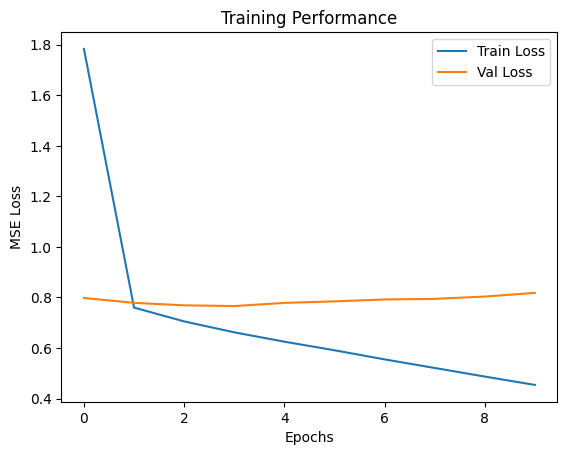

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Training Performance")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.show()

In [ ]:
def recommend_movies(user_id, top_n=5):
    user_movies = ratings[ratings['userId'] == user_id]['movieId'].values
    all_movies = np.array(list(set(ratings['movieId']) - set(user_movies)))

    user_array = np.array([user_id for _ in range(len(all_movies))])

    preds = model.predict([user_array, all_movies]).flatten()
    top_indices = preds.argsort()[-top_n:][::-1]

    preds = model.predict([user_array, all_movies]).flatten()
    top_indices = preds.argsort()[-top_n:][::-1]

    movie_map = pd.read_csv("ml-latest-small/movies.csv")
    movie_map['movieId'] = movie_map['movieId'].astype('category').cat.codes

    top_movies = movie_map[movie_map['movieId'].isin(all_movies[top_indices])]
    return top_movies[['title', 'genres']]

recommend_movies(user_id=10, top_n=5)

302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


,title,genres
6214,Game 6 (2005),Comedy|Drama
6782,Strange Circus (Kimyô na sâkasu) (2005),Horror|Mystery|Thriller
7584,American: The Bill Hicks Story (2009),Comedy|Documentary
7742,Immortals (2011),Action|Drama|Fantasy
8802,Too Late for Tears (1949),Crime|Drama|Film-Noir|Mystery|Thriller
